Import the libraries

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, udf, isnan, when, count
from pyspark.sql.types import DoubleType, IntegerType, DateType
import pandas as pd
import ibmos2spark, os
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

Establish the Spark Connection

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Read the Data from IBM Cloud

In [3]:
@hidden_cell
credentials = {
    'endpoint': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-c8ebc10c-e393-44ec-812e-ddb1c2dc4c68',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'DY8albLJOnB-2gBDvjbzAm8vQqpxmAxuXuAK736jeJy6'
}

configuration_name = 'os_c9080dc422914473bf3adbcfd9d664ed_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

AllData = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('format', 'csv')\
  .option('sep', ',')\
  .option('interSchema', 'true')\
  .load(cos.url('titanic.csv', 'default-donotdelete-pr-jqyjd8qpasasds'))

#Convert to accurate datatypes
AllData = AllData \
    .withColumn('Survived', col('Survived').cast(DoubleType())) \
    .withColumn('Pclass', col('Pclass').cast(DoubleType())) \
    .withColumn('Age', col('Age').cast(DoubleType())) \
    .withColumn('SibSp', col('SibSp').cast(DoubleType())) \
    .withColumn('Parch', col('Parch').cast(DoubleType())) \
    .withColumn('Fare', col('Fare').cast(DoubleType())) 

#List the datatypes of the columns
AllData.dtypes

[('PassengerId', 'string'),
 ('Survived', 'double'),
 ('Pclass', 'double'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'double'),
 ('Parch', 'double'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string')]

Describe the Data

In [4]:
AllData.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

Identify the number of missing values in the Data

In [5]:
from pyspark.sql.functions import isnan, when, count, col
AllData.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in AllData.columns]).show()

#Replace the missing values in the Age column with the mean of the column
age_mean = AllData.groupBy().mean('Age').first()[0]
AllData = AllData.na.fill({'Age':age_mean})
AllData.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+
|          1|     0.0|   3.0|Braund, Mr. Owen ...|  male|             22.0|  1.0|  0.0|       A/5 21171|   7.25| null|       S|
|          2|     1.0|   1.0|Cumings, Mrs. Joh...|female|             38.0|  

Split and Clean the Data

In [6]:
import pyspark.sql.functions as f
RoughFirstnameCol = udf(lambda name: name.split(',')[0].strip(),StringType())
AllData = AllData.withColumn('RoughFirstname', RoughFirstnameCol(AllData['Name']))

FirstnameCol = udf(lambda name: name.replace('"',''),StringType())
AllData = AllData.withColumn('Firstname', FirstnameCol(AllData['RoughFirstname']))



TitleCol = udf(lambda name: name.split(',')[1].strip(),StringType())
AllData = AllData.withColumn('Title1', TitleCol(AllData['Name']))

TitleCol1 = udf(lambda name: name.split('.')[0].strip(),StringType())
AllData = AllData.withColumn('Title', TitleCol1(AllData['Title1']))
 
OthernameCol1 = udf(lambda name: name.split('.')[1].strip(),StringType())
AllData = AllData.withColumn('Othernames1', OthernameCol1(AllData['Name']))

OthernameCol = udf(lambda name: name.split("(")[0].strip(),StringType())
AllData = AllData.withColumn('Othernames', OthernameCol(AllData['Othernames1']))


AllData = AllData.withColumn("Alias0", f.regexp_extract(col("Othernames1"), r"\(([^()]+)\)$", 1));
AllData = AllData.withColumn("Alias1", f.regexp_extract(col("Othernames1"), r'\"([^()]+)\"$', 1));

AllData = AllData.drop('AliasR')

from pyspark.sql.functions import concat, lit, col
 
AllData=AllData.select("*", concat(col("Alias0"),lit(" "),col("Alias1")).alias("AliasR"))

AllData = AllData.withColumn("Alias", f.regexp_replace(f.col("AliasR"), '[\()"]', "").alias("Alias"))
AllData.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+--------------+-------------+--------------------+------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|RoughFirstname|    Firstname|              Title1| Title|         Othernames1|          Othernames|              Alias0|Alias1|              AliasR|               Alias|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+--------------+-------------+--------------------+------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|          1|     0.0|   3.0|Braund, Mr. Owen ...|  male|             22.0|  1.0|  0.0|       A/5 21171|   7.

Drop Unnecessary columns

In [7]:
AllData = AllData.drop('Name', 'RoughFirstname','Title1',
                       'Othernames1','Alias0', 'Alias1',
                       'AliasR', 'PassengerId','Ticket',
                      'Cabin','Firstname','Alias','Othernames')

Convert Pyspark Dataframe to Pandas for Easy Analysis

In [8]:
AllData_pandas = AllData.toPandas()
AllData_pandas

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.0,3.0,male,22.000000,1.0,0.0,7.2500,S,Mr
1,1.0,1.0,female,38.000000,1.0,0.0,71.2833,C,Mrs
2,1.0,3.0,female,26.000000,0.0,0.0,7.9250,S,Miss
3,1.0,1.0,female,35.000000,1.0,0.0,53.1000,S,Mrs
4,0.0,3.0,male,35.000000,0.0,0.0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,male,27.000000,0.0,0.0,13.0000,S,Rev
887,1.0,1.0,female,19.000000,0.0,0.0,30.0000,S,Miss
888,0.0,3.0,female,29.699118,1.0,2.0,23.4500,S,Miss
889,1.0,1.0,male,26.000000,0.0,0.0,30.0000,C,Mr


The Ratio of Passengers That Survived to The Passengers That Died

Text(0.5, 1.0, 'Total Number of Passengers - Deaths and Survived on Titanic')

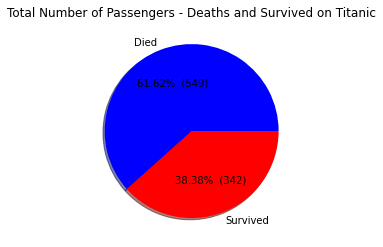

In [9]:
Passengers = AllData_pandas.groupby("Survived").size()
Passengers

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

import matplotlib.pyplot as plt
Passengers = AllData_pandas.groupby('Survived').size()

colors = ['blue', 'red', 'green', 'lightcoral']
plt.pie(Passengers, shadow = True, colors = colors, labels = ['Died', 'Survived'], autopct = make_autopct(Passengers))
plt.title('Total Number of Passengers - Deaths and Survived on Titanic')

Ratio of The Sex of Passengers That Survived to Passengers that Died

Text(0.5, 1.0, 'Total Number of Females and Males - Deaths and Survived on Titanic')

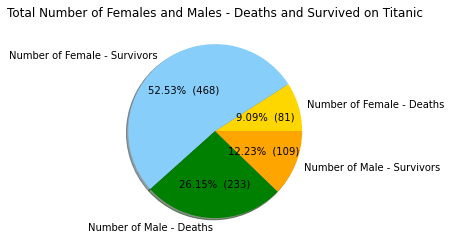

In [10]:
Sex = AllData_pandas.groupby(('Sex'))
survived_male_female = AllData_pandas.groupby(["Sex","Survived"]).size()

# Plot pie chart for Total Number of Females and Males - Deaths and Survived
Sex1 = AllData_pandas.groupby(['Survived', 'Sex']).size()
colors = ['gold','lightskyblue','green','orange']
plt.pie(Sex1, shadow = True, colors = colors, labels = ['Number of Female - Deaths', 'Number of Female - Survivors', 'Number of Male - Deaths', 'Number of Male - Survivors'], autopct = make_autopct(Sex1))
plt.title('Total Number of Females and Males - Deaths and Survived on Titanic')

Ratio of Passengers That survived to Passengers that Died Grouped by Passenger Class

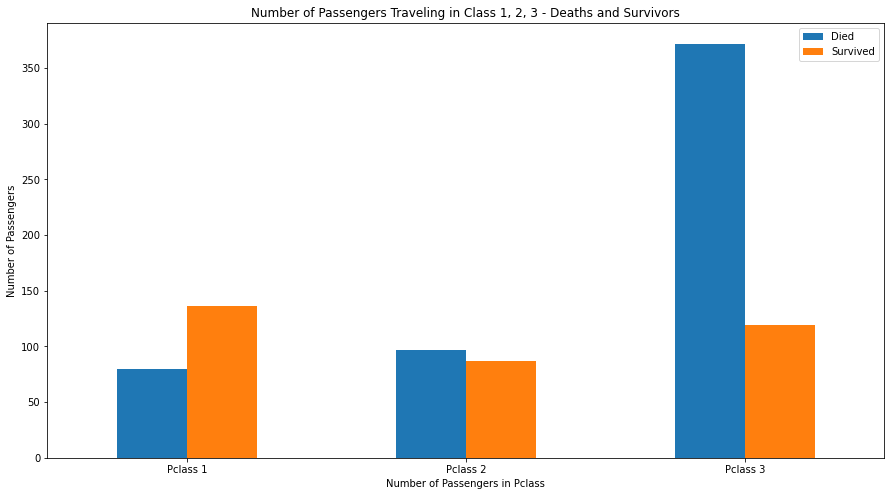

In [11]:
class_survived = AllData_pandas.groupby(["Pclass","Survived"]).size()
class_survived

objects = ('Pclass 1', 'Pclass 2', 'Pclass 3')
bars = np.arange(len(objects))
class_survived.unstack().plot(kind = "bar", figsize = (15,8))
plt.xticks(bars, objects, rotation='horizontal')
plt.ylabel("Number of Passengers")
plt.xlabel("Number of Passengers in Pclass")
plt.title("Number of Passengers Traveling in Class 1, 2, 3 - Deaths and Survivors")
plt.legend(['Died', 'Survived'])
plt.show()

Number of Passengers Grouped by Age

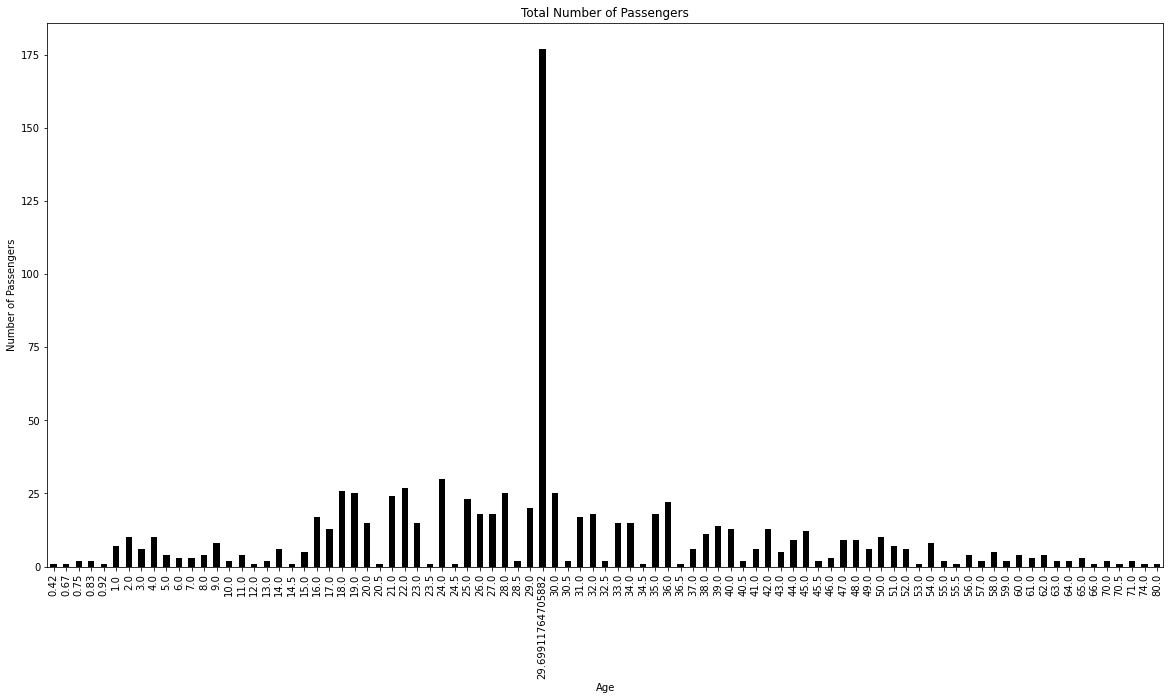

In [12]:
Age = AllData_pandas.groupby("Age").size()
Age

Age.plot(kind = "bar", color = 'black', figsize = (20,10))
plt.ylabel("Number of Passengers")
plt.xlabel("Age")
plt.title("Total Number of Passengers")
plt.show()

Statistical Description of Passengers Age

In [21]:
AllData_pandas["Age"].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

Number of Passengers Grouped by Number of Siblings/Spouse

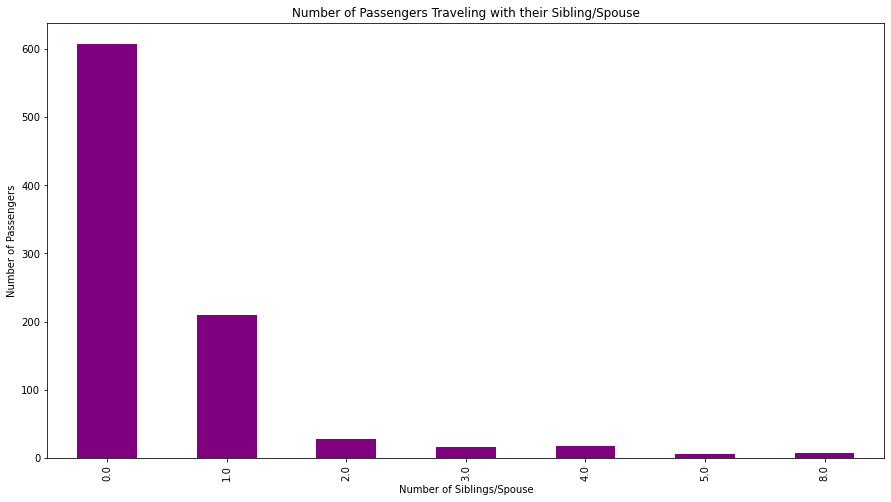

In [14]:
sibsp = AllData_pandas.groupby("SibSp").size()
sibsp

sibsp.plot(kind = "bar", figsize = (15,8), color = 'purple')
plt.ylabel("Number of Passengers")
plt.xlabel("Number of Siblings/Spouse")
plt.title("Number of Passengers Traveling with their Sibling/Spouse")
plt.show()

Number of Passengers Grouped by Those Traveling with Parents/Children

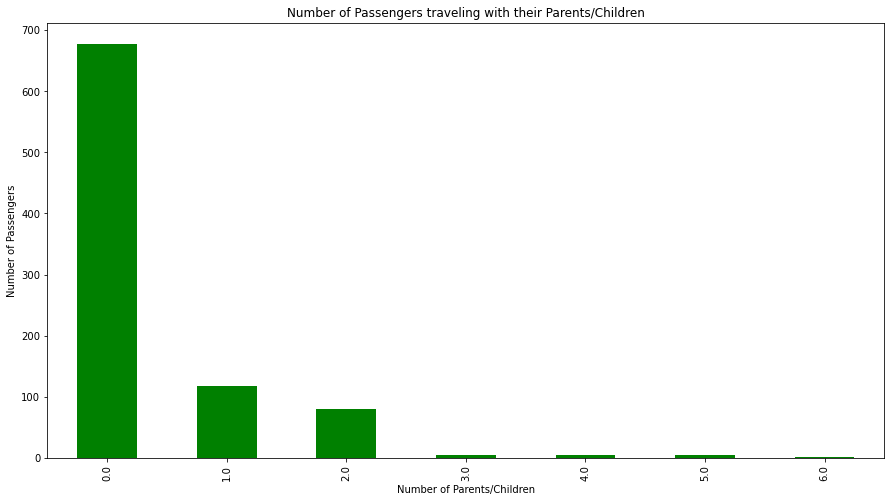

In [15]:
parch = AllData_pandas.groupby("Parch").size()
parch

parch.plot(kind = "bar", figsize = (15,8), color = 'g')
plt.ylabel("Number of Passengers")
plt.xlabel("Number of Parents/Children")
plt.title("Number of Passengers traveling with their Parents/Children")
plt.show()

Number of Passengers Grouped by Passenger Class

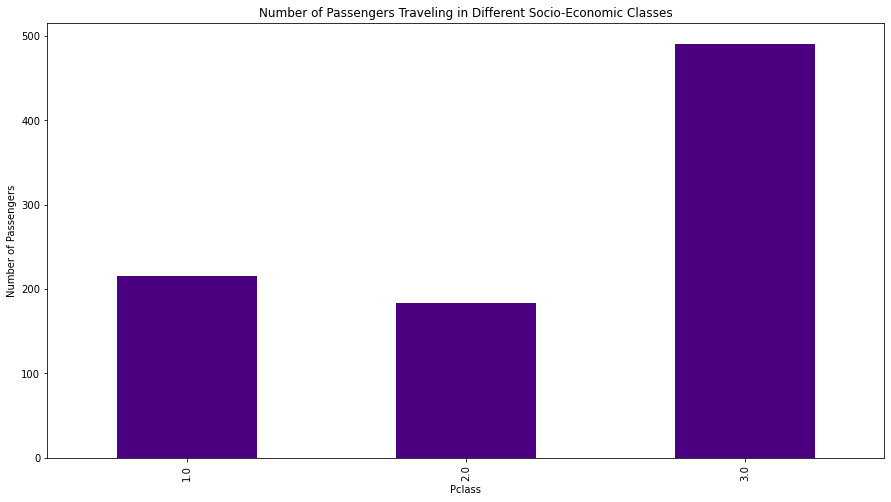

In [16]:
pclass = AllData_pandas.groupby("Pclass").size()
pclass

pclass.plot(kind = "bar", figsize = (15,8), color = 'indigo')
plt.ylabel("Number of Passengers")
plt.xlabel("Pclass")
plt.title("Number of Passengers Traveling in Different Socio-Economic Classes")
plt.show()

Establish The Pipeline

In [17]:
#Convert the strings to numeric values
Indexer = StringIndexer(inputCols = ['Sex','Title'], outputCols = ['Sex_indexed','Title_indexed'])

#Convert to sparse vectors
Encoder = OneHotEncoder(inputCols =['Sex_indexed','Title_indexed'], outputCols =['Sex_encoded','Title_encoded'])
    
#Vectorize the features
vectorassembler = VectorAssembler(inputCols=["Pclass",'Age','SibSp','Parch','Fare','Sex_encoded',
                                            'Title_encoded'], outputCol='features')
   

pipeline = Pipeline(stages = [Indexer, Encoder, vectorassembler])
AllData_transformed = pipeline.fit(AllData).transform(AllData)  
AllData_transformed.show()


+--------+------+------+-----------------+-----+-----+-------+--------+------+-----------+-------------+-------------+--------------+--------------------+
|Survived|Pclass|   Sex|              Age|SibSp|Parch|   Fare|Embarked| Title|Sex_indexed|Title_indexed|  Sex_encoded| Title_encoded|            features|
+--------+------+------+-----------------+-----+-----+-------+--------+------+-----------+-------------+-------------+--------------+--------------------+
|     0.0|   3.0|  male|             22.0|  1.0|  0.0|   7.25|       S|    Mr|        0.0|          0.0|(1,[0],[1.0])|(16,[0],[1.0])|(22,[0,1,2,4,5,6]...|
|     1.0|   1.0|female|             38.0|  1.0|  0.0|71.2833|       C|   Mrs|        1.0|          2.0|    (1,[],[])|(16,[2],[1.0])|(22,[0,1,2,4,8],[...|
|     1.0|   3.0|female|             26.0|  0.0|  0.0|  7.925|       S|  Miss|        1.0|          1.0|    (1,[],[])|(16,[1],[1.0])|(22,[0,1,4,7],[3....|
|     1.0|   1.0|female|             35.0|  1.0|  0.0|   53.1|       S

Drop Unncessary Columns

In [18]:
AllData_transformed = AllData_transformed.drop('Sex','Embarked','Title',
                       'Sex_indexed', 'Title_indexed','Pclass',
                                 'Age','SibSp','Parch','Fare','Sex_encoded',
                                             'Title_encoded','features_normalized','Survived')

In [19]:
AllData_transformed.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(22,[0,1,2,4,5,6]...|  0.0|
|(22,[0,1,2,4,8],[...|  1.0|
|(22,[0,1,4,7],[3....|  1.0|
|(22,[0,1,2,4,8],[...|  1.0|
|(22,[0,1,4,5,6],[...|  0.0|
|(22,[0,1,4,5,6],[...|  0.0|
|(22,[0,1,4,5,6],[...|  0.0|
|(22,[0,1,2,3,4,5,...|  0.0|
|(22,[0,1,3,4,8],[...|  1.0|
|(22,[0,1,2,4,8],[...|  1.0|
|(22,[0,1,2,3,4,7]...|  1.0|
|(22,[0,1,4,7],[1....|  1.0|
|(22,[0,1,4,5,6],[...|  0.0|
|(22,[0,1,2,3,4,5,...|  0.0|
|(22,[0,1,4,7],[3....|  0.0|
|(22,[0,1,4,8],[2....|  1.0|
|(22,[0,1,2,3,4,5,...|  0.0|
|(22,[0,1,4,5,6],[...|  1.0|
|(22,[0,1,2,4,8],[...|  0.0|
|(22,[0,1,4,8],[3....|  1.0|
+--------------------+-----+
only showing top 20 rows



Predictions of Machine Learning Models on the Train and Test Set

In [20]:
splits = AllData_transformed.randomSplit([0.8, 0.2], seed=10)
AllData_train = splits[0]
AllData_test = splits[1] 

#Fit the models to the data
rf = RandomForestClassifier(featuresCol= 'features', labelCol='label', numTrees = 100).fit(AllData_train)
 
logReg= LogisticRegression(featuresCol= 'features', labelCol='label',maxIter = 100, regParam = 0.05).fit(AllData_train)

 
#Define a function to predict and evaluate performance of the model on train data
def trainModel(model, Dataset = AllData_train):
    predictionstrain = model.transform(AllData_train)
    evaluator = BinaryClassificationEvaluator(labelCol = 'label')
    return evaluator.evaluate(predictionstrain)

print ('Performance on Train Data')
print ('AUC ROC of RandomForest model on train data: '+str(trainModel(rf)))
print ('AUC ROC of LogisticRegression model on train data: '+str(trainModel(logReg)))

print ('\n')

#Define a function to predict and evaluate performance of the model on test data
def testModel(model, Dataset = AllData_test):
    predictionstest = model.transform(AllData_test)
    evaluator = BinaryClassificationEvaluator(labelCol = 'label')
    return evaluator.evaluate(predictionstest)
 
print ('Performance on Test Data')
print ('AUC ROC of RandomForest model on test data: '+str(testModel(rf)))
print ('AUC ROC of LogisticRegression model on test data: '+str(testModel(logReg)))


Performance on Train Data
AUC ROC of RandomForest model on train data: 0.8822026885533829
AUC ROC of LogisticRegression model on train data: 0.8721248353429955


Performance on Test Data
AUC ROC of RandomForest model on test data: 0.8735391260162606
AUC ROC of LogisticRegression model on test data: 0.8976753048780489


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 10 rows

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       123
         1.0       0.79      0.72      0.75        64

    accuracy                           0.84       187
   macro avg       0.83      0.81      0.82       187
weighted avg       0.84      0.84      0.84       187



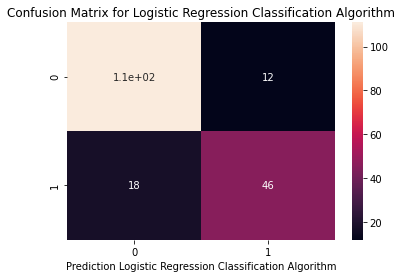

In [22]:
predictionstest = logReg.transform(AllData_test)
predictionstest.select('prediction' ,'label').show(10)

true = predictionstest.select(['label']).collect()
predicted = predictionstest.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true, predicted))

# Plot Confusion Matrix for Logistic Regression Classification Algorithm
confusion_matrix = confusion_matrix(true, predicted)
label = ["0", "1"]
sns.heatmap(confusion_matrix, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction Logistic Regression Classification Algorithm")
plt.title("Confusion Matrix for Logistic Regression Classification Algorithm")
plt.show()